In [228]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [229]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [279]:
import pandas as pd
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as KB
from keras.layers import Dense, Flatten, Input, Lambda, Conv1D
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR, SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score, classification_report

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.pipeline import make_pipeline



import tensorflow_hub as hub
import tensorflow_text as text

from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Embedding, GlobalAveragePooling1D
from keras.models import Sequential
from tensorflow.keras import Model

In [231]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [232]:
path_drive = "/content/drive/MyDrive/Colab Notebooks/P_6/Data_csv/flipkart_com-ecommerce_sample_1050.csv"
df = pd.read_csv(path_drive, sep = ',')

In [233]:
def preparing_label(texte):

    texte = texte.replace('[', '').replace(']', '').replace('"', '')
    #texte = texte.replace(' ', '')
    texte = texte.split('>>')
    texte = [word.lower() for word in texte]
    texte = [word.strip() for word in texte]
    #print(texte)


    return texte


In [234]:
def applying_changes(df, col_name, new_col_name):
    # Création nouvelle colonne dans df à partir de 'df[col_name]'
    #col_name = 'product_name'
    #new_col_name = 'product_name_tok'

    df[new_col_name] = 0
    df[new_col_name] = df[new_col_name].astype('str')

    df[new_col_name] = df[col_name].apply(preparing_label)

    return df



In [235]:


# Display the column names
print(df.columns)

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')


In [236]:


df = applying_changes(df, 'product_category_tree','cat_tree_cleaned')


In [237]:
def create_level_features(df, col_0, col_1):

    df[col_0] = 0
    df[col_0] = df[col_0].astype('str')

    s = df['cat_tree_cleaned']

    df[col_0] = s.apply(lambda x: x[0])

    df[col_1] = 0
    df[col_1] = df[col_1].astype('str')
    df[col_1] = s.apply(lambda x: x[1])

    return df


In [238]:
df = create_level_features(df, 'cat_level_0', 'cat_level_1')

In [239]:
# Encodage cat_level_0:

def encodage(df, col_0, col_1):

    s_0 = df[col_0]
    s_1 = df[col_1]

    le = LabelEncoder()

    df['cat_lev_0_enc'] = 0
    df['cat_lev_0_enc'] = le.fit_transform(s_0)
    print(le.fit_transform(s_0))

    df['cat_lev_1_enc'] = 0
    df['cat_lev_1_enc'] = le.fit_transform(s_1)
    print(le.fit_transform(s_1))

    return df


In [240]:
df = encodage(df, 'cat_level_0', 'cat_level_1')

[4 0 0 ... 0 0 0]
[19  1  1 ...  0  0  0]


In [241]:
# Input pour l'embedding:
X = df['product_name']
X = df['product_name'].apply(lambda mot: ''.join(mot))

y = df['cat_lev_0_enc']


print(type(X))
print(X.shape)
print(X[0:2])

<class 'pandas.core.series.Series'>
(1050,)
0    Elegance Polyester Multicolor Abstract Eyelet ...
1                           Sathiyas Cotton Bath Towel
Name: product_name, dtype: object


In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [243]:
print(X_train.shape)

(703,)


In [244]:
# URL du modèle que l'on va utiliser
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

# Chargement du modèle
used_model = hub.load(module_url)


In [245]:
def emb_func(X):

  return used_model(X)

In [246]:
X = pd.Series(data='je veux que notre planète reste en bon état')

In [247]:
X.shape

(1,)

In [248]:
emb_func(X)

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 3.72392715e-05, -8.90110582e-02, -6.46801069e-02,
         5.46339620e-03, -1.20840557e-02, -1.78199485e-02,
        -7.30876774e-02, -4.13663052e-02,  1.41468076e-02,
        -4.83076051e-02,  2.00272519e-02,  5.69164695e-04,
        -7.89791346e-02,  3.89828393e-03,  1.30515853e-02,
        -8.50399211e-02, -1.35094170e-02,  1.60339549e-02,
        -2.26377454e-02, -3.58069711e-03, -7.44769126e-02,
        -4.66053039e-02,  7.60171488e-02,  1.06246240e-01,
         1.25352647e-02,  1.37945674e-02, -2.55780946e-02,
        -5.86765306e-03,  8.85574073e-02,  8.03215243e-03,
        -1.75588508e-03, -2.10909862e-02, -3.92659493e-02,
        -2.74026711e-02,  2.34836247e-02,  1.81154665e-02,
         3.68975587e-02,  9.17178404e-04, -1.44123062e-02,
        -2.10646968e-02,  7.25063458e-02, -8.38850513e-02,
        -2.94916648e-02,  1.27617409e-02, -1.98545381e-02,
         3.75275798e-02, -3.88997756e-02,  4.68930155e-02,
      

In [249]:
used_model(X).shape

TensorShape([1, 512])

In [250]:
from unicodedata import name
inp_layer = tf.keras.layers.Input(shape=(), dtype=tf.string)
embedding_layer = tf.keras.layers.Lambda(emb_func, trainable=True)(inp_layer)
dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(embedding_layer)
dense_2 = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(dense_1)
dense_3 = tf.keras.layers.Dense(32, activation='relu', name='dense_3')(dense_2)
output = tf.keras.layers.Dense(7, activation='softmax', name='output_layer')(dense_3)
model_nn = tf.keras.Model(inputs=[inp_layer], outputs=output)
model_nn.summary()


The following Variables were used a Lambda layer's call (lambda_6), but
are not present in its tracked objects:
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_29:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_28:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_27:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_26:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_25:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_24:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/AdjustDepth/projection/kernel/part_23:0' shape=(10, 512) dtype=float32>
  <tf.Variable 'EncoderDNN/DNN/ResidualHidden_3/

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None,)]                 0         
                                                                 
 lambda_6 (Lambda)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 output_layer (Dense)        (None, 7)                 231       
                                                                 
Total params: 76,231
Trainable params: 76,231
Non-trainable

In [251]:
model_nn.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )


In [252]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [253]:
n_batches = 50
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1, save_weights_only=True,
                                                 save_freq=5*n_batches)

In [254]:
callback = EarlyStopping(monitor='val_loss', patience = 5, min_delta = 0.0001, restore_best_weights = True)

In [255]:
from keras.api._v2.keras import callbacks
model_nn.fit(X_train, y_train,
                   batch_size = 32, epochs = 10,
                   verbose = 2, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
22/22 - 6s - loss: 1.8370 - accuracy: 0.4211 - val_loss: 1.6248 - val_accuracy: 0.6023 - 6s/epoch - 287ms/step
Epoch 2/10
22/22 - 0s - loss: 1.2911 - accuracy: 0.7326 - val_loss: 0.9321 - val_accuracy: 0.8127 - 366ms/epoch - 17ms/step
Epoch 3/10
22/22 - 0s - loss: 0.6459 - accuracy: 0.8947 - val_loss: 0.4738 - val_accuracy: 0.8732 - 387ms/epoch - 18ms/step
Epoch 4/10
22/22 - 0s - loss: 0.3236 - accuracy: 0.9232 - val_loss: 0.3347 - val_accuracy: 0.8876 - 378ms/epoch - 17ms/step
Epoch 5/10
22/22 - 0s - loss: 0.2097 - accuracy: 0.9431 - val_loss: 0.2823 - val_accuracy: 0.8876 - 376ms/epoch - 17ms/step
Epoch 6/10
22/22 - 0s - loss: 0.1490 - accuracy: 0.9616 - val_loss: 0.2843 - val_accuracy: 0.9020 - 375ms/epoch - 17ms/step
Epoch 7/10
22/22 - 0s - loss: 0.1206 - accuracy: 0.9644 - val_loss: 0.2683 - val_accuracy: 0.8934 - 373ms/epoch - 17ms/step
Epoch 8/10
22/22 - 0s - loss: 0.0893 - accuracy: 0.9801 - val_loss: 0.2793 - val_accuracy: 0.8905 - 375ms/epoch - 17ms/step
Epoch 9/10

In [256]:
model_nn.save_weights(checkpoint_path.format(epoch=0))

In [257]:
os.listdir(checkpoint_dir)

['cp-0000.ckpt.index', 'checkpoint', 'cp-0000.ckpt.data-00000-of-00001']

In [258]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0000.ckpt'

In [259]:
model_nn.load_weights(latest)

y_pred = model_nn.predict(X_test, batch_size = len(X_test))

1/1 [==============================] - 0s 439ms/step


In [260]:
y_train.shape, y_pred.shape

((703,), (347, 7))

In [261]:
X_train = used_model(X_train).numpy()
X_test = used_model(X_test).numpy()


In [265]:
def pipeline_svc(X_train,y_train):

    print(X_train.shape)

    # Transformers utilisés
    svm_classifier = SVC()
    scaler = MinMaxScaler()

    # Fit pipeline
    pipe = make_pipeline(scaler, svm_classifier)
    pipe.fit(X_train, y_train)

    # Predict pipeline
    y_pred = pipe.predict(X_test)

    # Metrics
    score = metrics.accuracy_score(y_test, y_pred)

    return score, y_pred, pipe







In [266]:
score, y_pred, pipe_fitted = pipeline_svc(X_train,y_train)[0], pipeline_svc(X_train,y_train)[1], pipeline_svc(X_train,y_train)[2]

(703, 512)
(703, 512)
(703, 512)


In [270]:
def display_score(score):
  print("--------------------------------")
  print("Score accuracy: {}".format(score))
  print("--------------------------------")


  return

In [272]:
display_score(score)

--------------------------------
Score accuracy: 0.9279538904899135
--------------------------------


In [277]:
def conf_matrix():
    classes = pipe_fitted.steps[1][1].classes_

    print(classes)

    cm = confusion_matrix(y_test, y_pred, labels=classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

    return

[0 1 2 3 4 5 6]


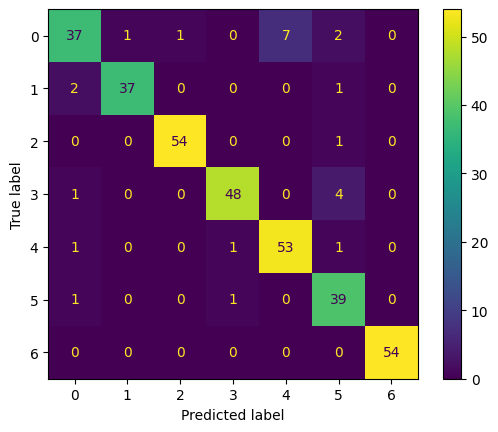

In [280]:
conf_matrix()

In [281]:
def metrics_report():
  return print(classification_report(y_test, y_pred))

In [282]:
metrics_report()

              precision    recall  f1-score   support

           0       0.88      0.77      0.82        48
           1       0.97      0.93      0.95        40
           2       0.98      0.98      0.98        55
           3       0.96      0.91      0.93        53
           4       0.88      0.95      0.91        56
           5       0.81      0.95      0.88        41
           6       1.00      1.00      1.00        54

    accuracy                           0.93       347
   macro avg       0.93      0.93      0.92       347
weighted avg       0.93      0.93      0.93       347

